In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torchvision import transforms
from torchvision import models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

%matplotlib inline

In [2]:
print(torch.__version__)


1.0.0


In [3]:
use_cuda = torch.cuda.is_available() 
if use_cuda : 
    print("cuda")
else :
    print("illa")    

cuda


In [4]:
import os
from torchvision import datasets
import torchvision.transforms as transforms
import torch

data_dir = 'C:/Users/DMLaptopWindows1/Desktop/dermatologist-ai/data'
train_dir = data_dir + '/train/train'
valid_dir = data_dir + '/valid/valid'
test_dir  = data_dir + '/test/test'

data_transforms = {'train': transforms.Compose([transforms.RandomResizedCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])]),
                   'valid': transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])]),
                   'test': transforms.Compose([transforms.Resize(size=(224,224)),
                                     transforms.ToTensor(), 
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])])
                    
}
train_data= datasets.ImageFolder(train_dir, transform=data_transforms['train'])
test_data= datasets.ImageFolder(test_dir, transform=data_transforms['test'])
valid_data= datasets.ImageFolder(valid_dir, transform=data_transforms['valid'])

dataloaders={ 'train' : torch.utils.data.DataLoader(train_data, batch_size=2,num_workers=0, shuffle=True),
              'valid' : torch.utils.data.DataLoader(valid_data,batch_size=2, num_workers=0,shuffle=False),
              'test'  : torch.utils.data.DataLoader(test_data,batch_size=2,num_workers=0,shuffle=False)
    
}

In [5]:
loaders_transfer = dataloaders.copy()

In [6]:
import torchvision.models as models
import torch.nn as nn

model_transfer = models.resnet152(pretrained=True)

for param in model_transfer.parameters():
    param.requires_grad = True

model_transfer.fc = nn.Linear(2048,3)
fc_parameters = model_transfer.fc.parameters()

for param in fc_parameters:
    param.requires_grad = True

use_cuda = torch.cuda.is_available()   

print(model_transfer)
if use_cuda:
    model_transfer = model_transfer.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [7]:
model_transfer.load_state_dict(torch.load('final.pth'))

In [8]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.Adam(model_transfer.fc.parameters(), lr=0.0000001)


In [10]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx,(data,target) in enumerate(dataloaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()
            output=model(data)
            loss=criterion(output,target)
            loss.backward()
            optimizer.step()
            
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            if batch_idx%50==0:
                 print('Epoch: {} \tTraining Loss: {:.6f} '.format(epoch,train_loss))
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data,target) in enumerate(dataloaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            output=model(data)
            loss=criterion(output,target)
            loss.backward()
            optimizer.step()
            
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        if valid_loss<valid_loss_min:
            torch.save(model.state_dict(), save_path)
            valid_loss_min=valid_loss
            print("Saving your model ...............................")
        
        
    return model

In [ ]:
model_transfer = train(20, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

In [11]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(dataloaders['test']):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        output = model(data)
        loss = criterion(output, target)
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        pred = output.data.max(1, keepdim=True)[1]
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [12]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 1.012556


Test Accuracy: 65% (393/600)


In [13]:
torch.save(model_transfer.state_dict(), 'final.pth')

In [14]:
from PIL import Image
from torch.autograd import Variable

class_names = [item[:].replace("_", " ") for item in loaders_transfer['train'].dataset.classes]

def skin_detector(img_path):
    image_transform=transforms.Compose([transforms.RandomResizedCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])])
    image = image_transform(Image.open(img_path))
    image = image.unsqueeze(0)
    prob_class = False
    
    if use_cuda:
        prob_class = model_transfer.forward(Variable(image.cuda())).cpu()
    else:
        prob_class = model_transfer.forward(Variable(image))
    
    return class_names[prob_class.data.numpy().argmax()]

In [15]:
from PIL import Image
from torch.autograd import Variable

def predict_cancer(img_path):
    skin = skin_detector(img_path)
    img = plt.imread(img_path)
    fig, ax = plt.subplots()
    ax.imshow(img)
    if (skin):
        print(skin_detector(img_path))

nevus


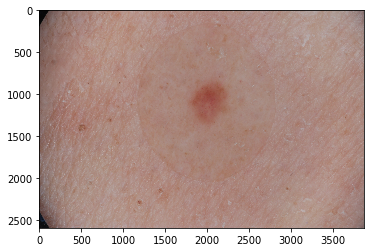

In [16]:
predict_cancer(test_dir + '/nevus/ISIC_0013226.jpg')

melanoma


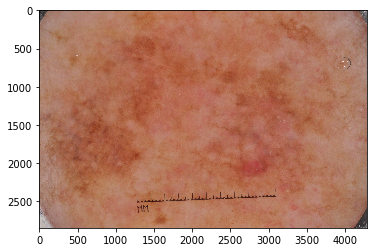

In [19]:
predict_cancer(test_dir + '/melanoma/ISIC_0013833.jpg')

seborrheic keratosis


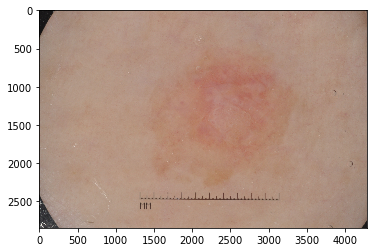

In [18]:
predict_cancer(test_dir + '/seborrheic_keratosis/ISIC_0014500.jpg')